# Weak lensing – Notebook 5th April 2024

Notebook tested with commit nb `a8a25e441996bbda61298608c46db620666f26f9`.

Check requirements in `env.yml` (conda virtual environment).

The `pycs` package from the `cosmostat` repository (https://github.com/CosmoStat/cosmostat) could not be installed with `pip install .`. Therefore, the path to the git repository must be added to `PYTHONPATH` (see below). Tested with commit nb `2474c0332f926cc90c7b4c15bb19ee4b459ba3fc`.

The `pysparse` package from the `Sparse2D` repository  (https://github.com/CosmoStat/Sparse2D) needs to be manually installed. Tested with commit nb `3f9d54863765980299cfe92e0624ba93ed7ff02b`.

Very dirty workaround to avoid `ImportError: libpython3.11.so.1.0: cannot open shared object file: No such file or directory`: create a symbolic link from the `libpython3.11.so.1.0` file, which is typically stored in the `~/miniconda3/envs/wl-pycs/lib` (i.e., the directory for shared libraries within the virtual environment), to a standard root location such as `/lib/x86_64-linux-gnu`.

In [1]:
%matplotlib inline

import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import weaklensing as wl
import weaklensing.utils as wlutils
import weaklensing.kappatng as wlktng
import weaklensing.cosmos as wlcosmos

pycs_dir = os.path.expanduser(wl.CONFIG_DATA['pycs_dir'])
sys.path.append(pycs_dir) # tested with commit nb 2474c0332f926cc90c7b4c15bb19ee4b459ba3fc)
print(f"The `pycs` package is located in {pycs_dir}")

import pycs.astro.wl.mass_mapping as csmm

Configuration file found in /home/leterme231/OneDrive/Documents/Code/weaklensing
The `pycs` package is located in /home/leterme231/OneDrive/Documents/Code/cosmostat


## Figures for presentation 2024-04-10

In [2]:
size = 1.5
width, size = wlktng.get_npixels(size)
Nsigma = 4
print(f"Nb of pixels per side = {width}")
print(f"Opening angle = {size:.2f} deg")

Nb of pixels per side = 306
Opening angle = 1.49 deg


Load kappaTNG dataset

In [3]:
index_redshift = 2
ninpimgs = 1
kappa = wlktng.kappa_tng(index_redshift, ninpimgs, width=width)

Load data from the COSMOS catalog

In [4]:
cat_cosmos = wlcosmos.cosmos_catalog(
    include_faint=False
)
data_cosmos = wlcosmos.get_data_from_cosmos(cat_cosmos, size)
extent = data_cosmos["extent"]
cosmos_mask, ra, dec = wlcosmos.cosmos_boundaries(extent, width)

In [5]:
shapedisp1, shapedisp2 = data_cosmos["shapedisp"]
shapedisp = (shapedisp1 + shapedisp2) / 2

print(f"Shape dispersion 1 = {shapedisp1:.3f}")
print(f"Shape dispersion 2 = {shapedisp2:.3f}")

Shape dispersion 1 = 0.278
Shape dispersion 2 = 0.279


In [6]:
print(f"Resolution = {wlktng.RESOLUTION:.2f} arcmin/pixel")

Resolution = 0.29 arcmin/pixel


Map of number of galaxies per pixel

In [7]:
ngal = wlutils.ngal_per_pixel(cat_cosmos["Ra"], cat_cosmos["Dec"], width, extent)

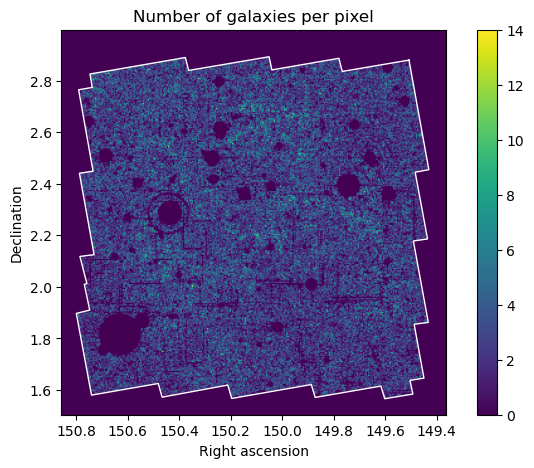

In [8]:
plt.figure(figsize=(8, 5))
wlutils.skyshow(
    ngal, extent=extent, boundaries=(ra, dec), title="Number of galaxies per pixel"
)
plt.show()

Create noisy shear maps

In [9]:
gamma1, gamma2 = wlutils.get_shear_from_convergence(kappa)
gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
    gamma1, gamma2, ngal, shapedisp, stdnoise_mask=0
)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:141: RuntimeWarning: divide by zero encountered in divide
  shapedisp / np.sqrt(ngal), posinf=stdnoise_mask


In [10]:
idx = 0
vmin = np.min(kappa)
vmax = np.max(kappa)
vmin_gamma = min(np.min(gamma1), np.min(gamma2))
vmax_gamma = max(np.max(gamma1), np.max(gamma2))
saturation = 0.8
saturation_gamma = 0.6

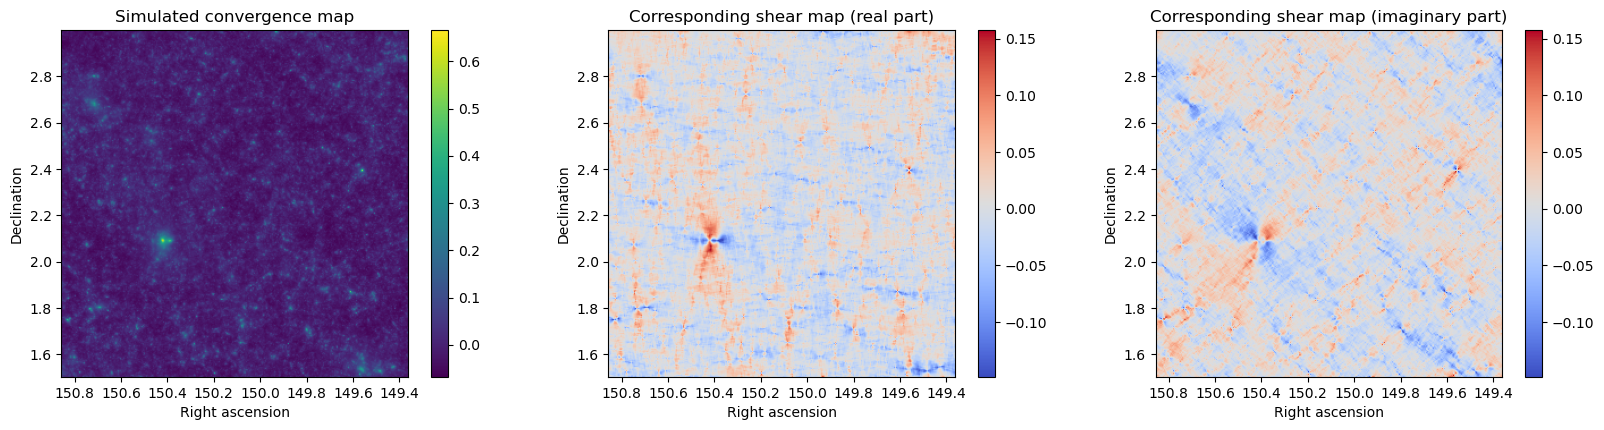

In [11]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    title="Simulated convergence map"
)
plt.subplot(132)
wlutils.skyshow(
    gamma1[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, c='k', title="Corresponding shear map (real part)"
)
plt.subplot(133)
wlutils.skyshow(
    gamma2[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, c='k', title="Corresponding shear map (imaginary part)"
)
plt.show()

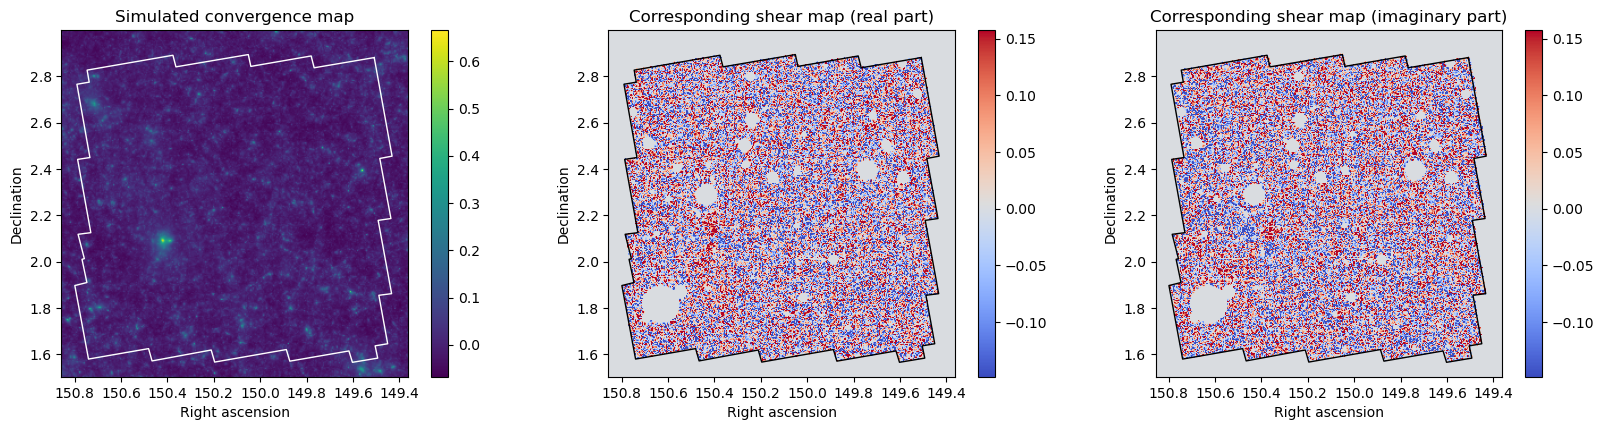

In [12]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Simulated convergence map"
)
plt.subplot(132)
wlutils.skyshow(
    gamma1_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', title="Corresponding shear map (real part)"
)
plt.subplot(133)
wlutils.skyshow(
    gamma2_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', title="Corresponding shear map (imaginary part)"
)
plt.show()

Register data into a `csmm.shear_data` object

In [13]:
sheardata = csmm.shear_data()
sheardata.g1 = gamma1_noisy
sheardata.g2 = gamma2_noisy
sheardata.mask = (ngal > 0).astype(int)
sheardata.Ncov = 2 * std_noise**2 # factor 2 required

Create a mass mapping structure and initialize it

In [14]:
massmap = csmm.massmap2d(name='mass')
massmap.init_massmap(width, width)
massmap.DEF_Nsigma = Nsigma

print(f"Number of iterations (iterative methods): {massmap.DEF_niter}")
print(f"Detection level in wavelet space: {massmap.DEF_Nsigma}")

Number of iterations (iterative methods): 12
Detection level in wavelet space: 4


### Kaiser-Squires estimator

In [15]:
kappa_ks_unsmoothed = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy,
    std_noise=std_noise, get_bounds=False, smooth=False
)
kappa_ks = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy,
    std_noise=std_noise, get_bounds=False
)

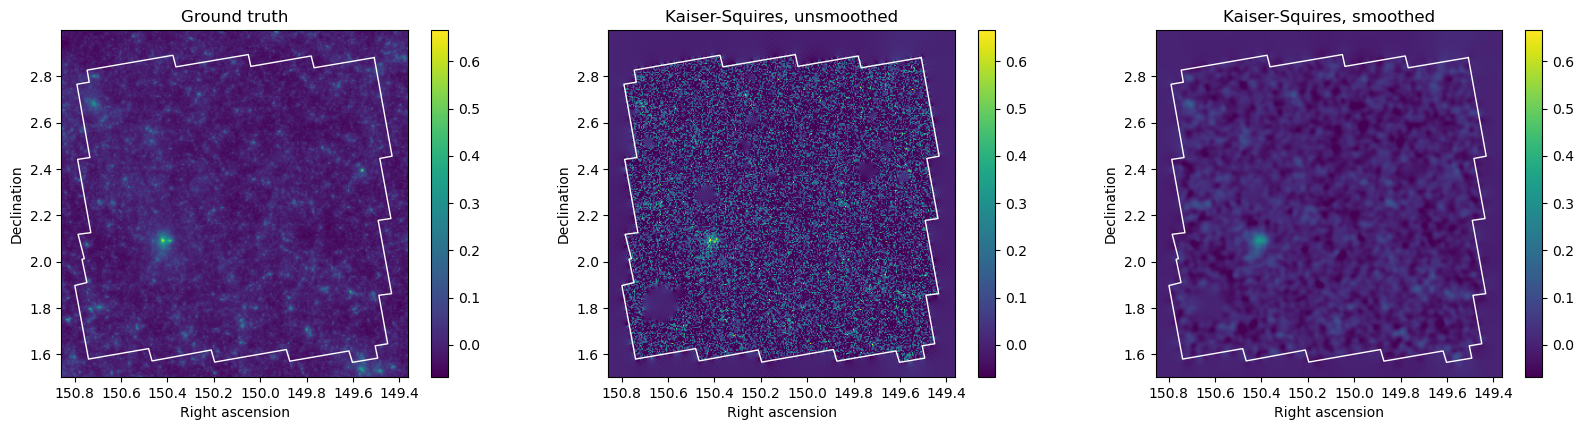

In [16]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_ks_unsmoothed[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Kaiser-Squires, unsmoothed"
)
plt.subplot(133)
wlutils.skyshow(
    kappa_ks[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Kaiser-Squires, smoothed"
)
plt.show()

### MLE estimator

In [17]:
kappa_mle_unsmoothed, _ = massmap.prox_mse(
    sheardata, Inpaint=False
)
kappa_mle, _ = massmap.prox_mse(
    sheardata, Inpaint=False, sigma=wlutils.STD_KSGAUSSIANFILTER
)

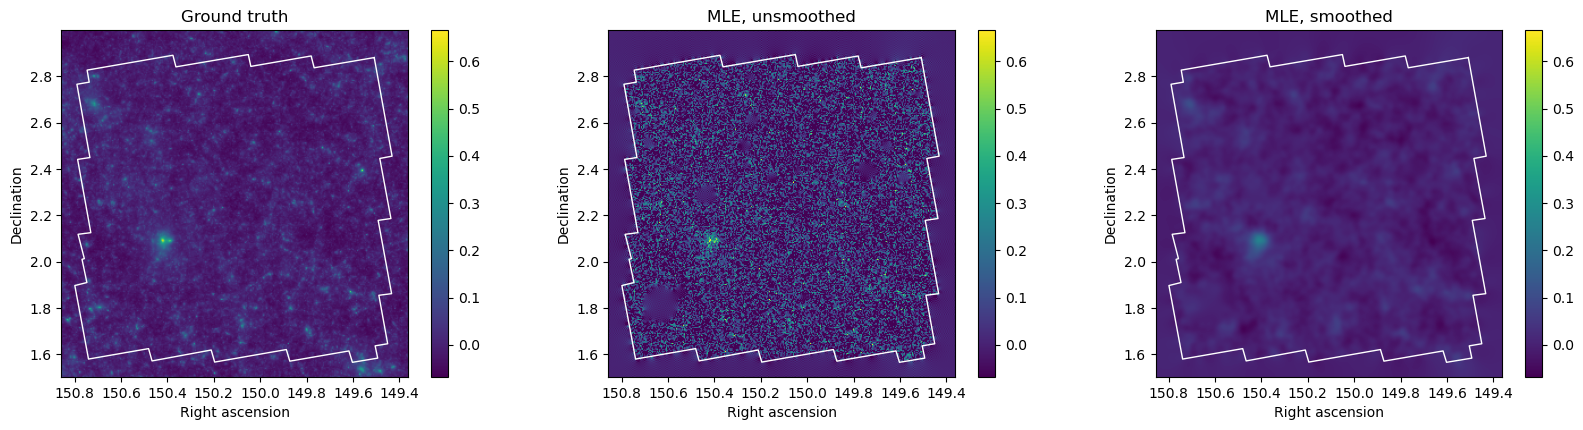

In [18]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_mle_unsmoothed[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="MLE, unsmoothed"
)
plt.subplot(133)
wlutils.skyshow(
    kappa_mle[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="MLE, smoothed"
)
plt.show()

### Compute the 1D power spectrum from simulated convergence maps

In [19]:
# Load new set of convergence maps
# (the power spectrum shouldn't be computed on the calibration or test sets)
ninpimgs_ps = 20
kappa_ps = wlktng.kappa_tng(index_redshift, ninpimgs_ps, start_idx=ninpimgs, width=width)

In [20]:
powerspectrum = np.mean(np.abs(np.fft.fft2(kappa_ps) / width)**2, axis=0) # expected value of the squared Fourier modulus
powerspectrum = powerspectrum[:width//2, :width//2] # only positive frequencies, by symmetry
powerspectrum_1d = (powerspectrum[0, :] + powerspectrum[:, 0]) / 2 # assumed isotropic
%xdel kappa_ps

### Wiener estimator

In [21]:
kappa_wiener, _ = massmap.prox_wiener_filtering(
    sheardata, powerspectrum_1d, Inpaint=False
)

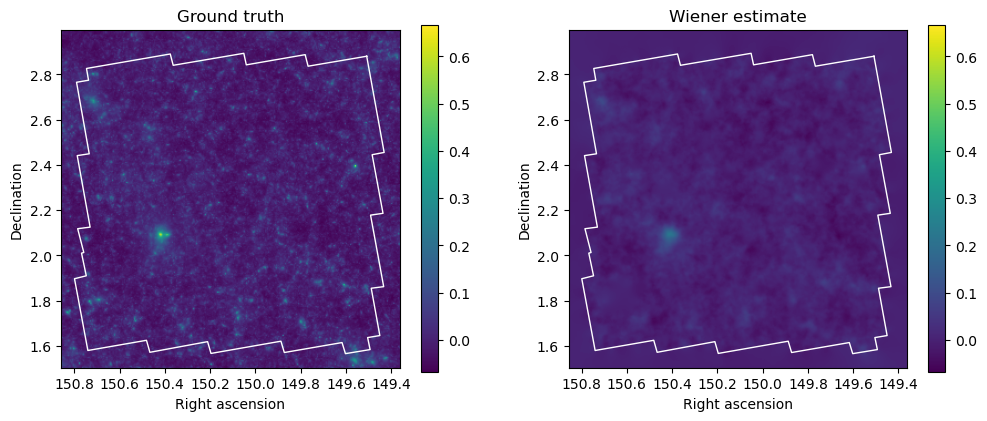

In [22]:
plt.figure(figsize=(12, 4.5))
plt.subplot(121)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(122)
wlutils.skyshow(
    kappa_wiener[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Wiener estimate"
)
plt.show()

### MCALens estimator

In [23]:
Nsigma = 4

In [24]:
kappa_mcalens, _, kappa_sparse, _ = massmap.sparse_wiener_filtering(
    sheardata, powerspectrum_1d, Nsigma=Nsigma, Inpaint=False, Bmode=False
)

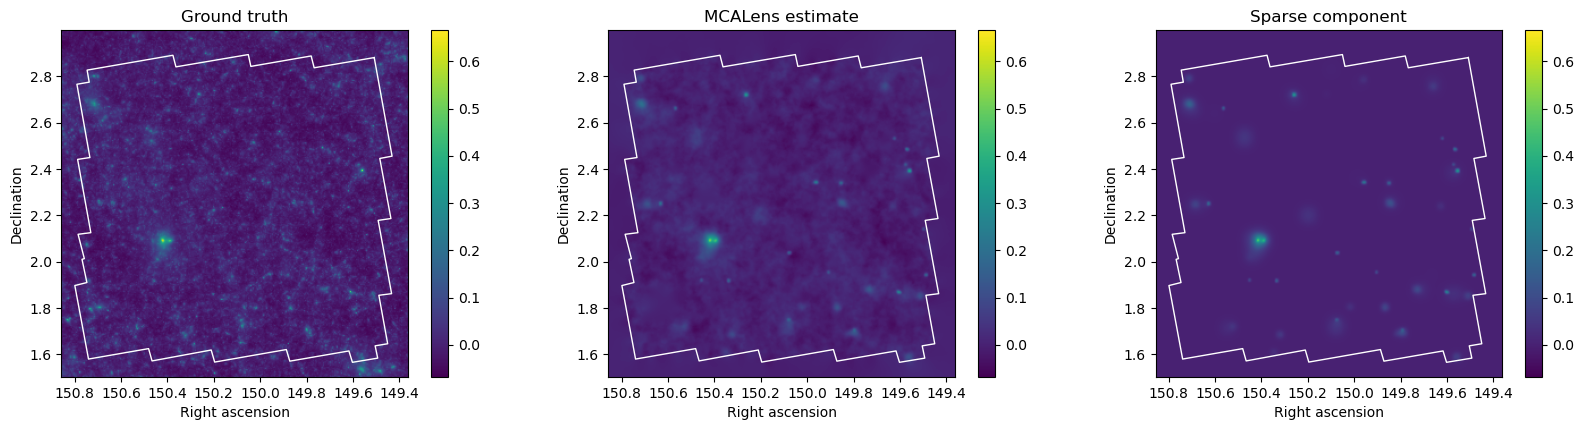

In [25]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_mcalens[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="MCALens estimate"
)
plt.subplot(133)
wlutils.skyshow(
    kappa_sparse[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Sparse component"
)
plt.show()